In [ ]:
#Extra Code
from numpy.random import normal
from numpy import hstack
import seaborn as sns

# generate a sample
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))

# generate the histogram
dist_counts, dist_bins = numpy.histogram(sample, bins=50)

plt.plot(dist_bins[:-1], dist_counts)
plt.show()

# plotting density plot for carat using distplot()
sns.kdeplot(sample) #Smoothed version of the histogram

# visualizing plot using matplotlib.pyplot library
plt.show()

In [2]:
#Loading all libraries
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel, logging
from datasets import load_dataset
import torch

logging.set_verbosity(50)

model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)

print(f'{model_checkpoint} loaded...')

distilbert-base-uncased loaded...


In [42]:
def gen_samples(dataset_name, number_of_samples = 500):
    dataset = load_dataset(dataset_name)
    randomly_sampled_data = random.sample(range(dataset['train'].num_rows), number_of_samples)
    sampled_dataset = dataset['train'][randomly_sampled_data]
    samples = np.array([torch.sum(model.get_input_embeddings()(tokenizer(x, y, stride=128, truncation='only_second', return_tensors='pt')['input_ids']), dim=1).squeeze(0).detach().numpy() 
           for x, y in zip(sampled_dataset['question'], sampled_dataset['context'])])
    return samples

samples = gen_samples("covid_qa_deepset")
#samples = gen_samples('squad')

Reusing dataset covid_qa_deepset (/home/saptarshi/.cache/huggingface/datasets/covid_qa_deepset/covid_qa_deepset/1.0.0/fb886523842e312176f92ec8e01e77a08fa15a694f5741af6fc42796ee9c8c46)


  0%|          | 0/1 [00:00<?, ?it/s]

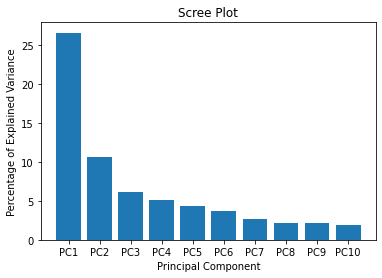

In [43]:
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(samples)

pca = PCA(n_components=10) # create a PCA object
pca_data = pca.fit_transform(scaled_data) # get PCA coordinates for scaled_data

#The following code constructs the Scree plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

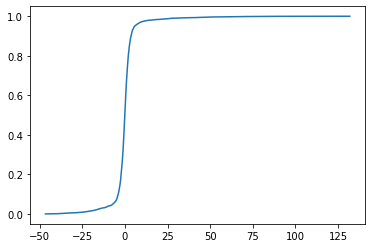

In [41]:
#ECDF stuff
ecdf_squad = ECDF(pca_data.reshape(1,-1).squeeze(0))

# plot the cdf
plt.plot(ecdf_squad.x, ecdf_squad.y)
plt.show()

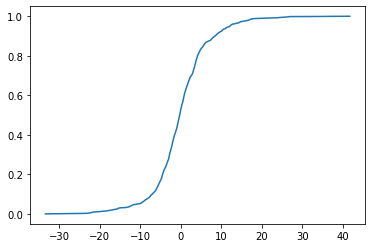

In [44]:
ecdf_covid_qa = ECDF(pca_data.reshape(1,-1).squeeze(0))

# plot the cdf
plt.plot(ecdf_covid_qa.x, ecdf_covid_qa.y)
plt.show()

In [46]:
from scipy.special import rel_entr
kl_pq = rel_entr(ecdf_squad.y, ecdf_covid_qa.y)
print('KL(P || Q): %.3f nats' % sum(kl_pq))
kl_qp = rel_entr(ecdf_covid_qa.y, ecdf_squad.y)
print('KL(Q || P): %.3f nats' % sum(kl_qp))

KL(P || Q): 0.000 nats
KL(Q || P): 0.000 nats
